## Computation of the OPE coefficients for the Ising model


In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.sparse.linalg import eigsh

from Levin_trg import *
from Initialization import initialize_Ising
PI=np.pi

In [2]:
Tc=2./np.log(np.sqrt(2)+1)

### First, we make a list of renormalized tensor $T^{(n)}$

In [3]:
def TRG_cft(T, D_cut):
    RG_steps = 12
    A = initialize_Ising(T)
    A, factor = normalize_tensor(A)
    A_list = [A]
    c_charge=[]
    for i in tqdm(range(RG_steps)):
        A = TRG_step(A,D_cut)
        A, factor = normalize_tensor(A)
        A_list.append(A)
        M = np.einsum("rurd->ud",A/factor)
        u,s,v = np.linalg.svd(M)
        c_charge.append(np.log(s[0])*12./(2.*PI))
    return c_charge, A_list

In [4]:
c, A_list = TRG_cft(Tc, 64)

100%|███████████████████████████████████████████| 12/12 [01:56<00:00,  9.74s/it]


### The computed central charge is close to the theoretical value $c=\frac{1}{2}$

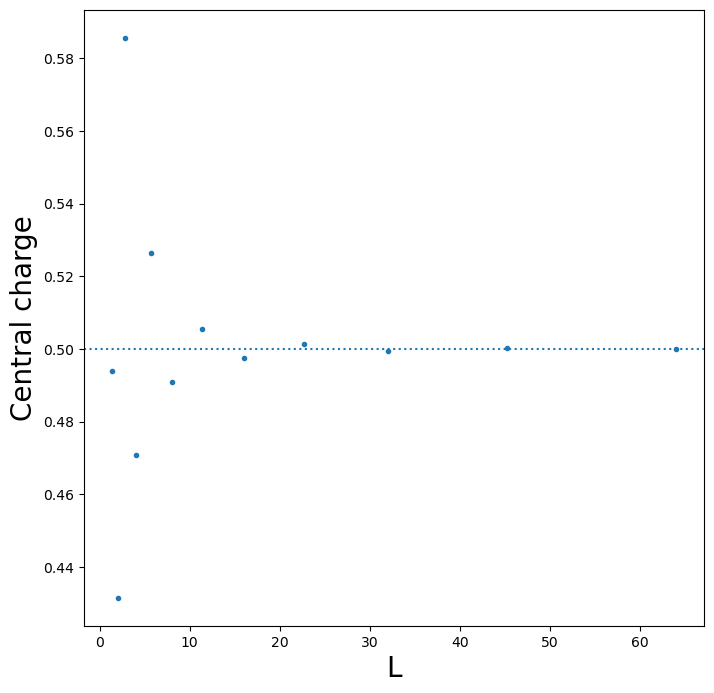

In [5]:
plt.figure(figsize=(8,8))
plt.plot(np.sqrt(2)**(1+np.arange(len(c))),c,".")
plt.xlabel("L",fontsize=20)
plt.ylabel("Central charge",fontsize=20)
plt.axhline(0.5,linestyle=":")

## Obtain $\psi_n(L)$ and $\psi_n(2L)$ by diagonalizing the transfer matrix

In [6]:
#calculate the small(L) and large(2L) vectors.
def cal_sl_vec(A, num_primary):
    d = A.shape[0]
    #calculation of the small vectors
    mat= np.einsum("isjs->ij",A)
    val, vec = eigsh(mat, k = num_primary + 1, which = "LM")
    small_vec = vec[:,::-1]
    #calculation of the large vectors
    mat = np.einsum("ijkl, kmin->jmln", A, A).reshape(d*d, d*d)
    val, vec = eigsh(mat, k = num_primary + 1, which = "LM")
    large_vec = vec[:,::-1]
    return small_vec, large_vec

## Calculate the overlap 

In [7]:
from ncon import ncon
#<v1|v2v3>
def fusion_vec(vec1, vec2, vec3):
    dsq = int(np.sqrt(len(vec1)))
    return ncon([vec1.reshape(dsq,dsq), vec2, vec3], [[1,2], [1], [2]])

def fusion_table(s_vector, l_vector):
    # <vi | vj vk>, v = {0, σ, ε }
    table = np.zeros((3,3,3))
    for i in range(3):
        for j in range(3):
            for k in range(3):
                table[i, j, k] = fusion_vec(l_vector[:,i], s_vector[:,j], s_vector[:,k])
    return table

"""
table: table of the wavefunciton overlap (α, β, γ) -> <ψα |ψβψγ>
sd : scaling dimension Δα
Aαβγ=<ψα|ψβψγ> = table[α,β,γ]
"""
def cal_OPE(table, sd, alpha, beta, gamma):
    AIII = np.abs(table[0,0,0])
    Aabc= np.abs(table[alpha, beta, gamma])
    c=Aabc/AIII/2**(sd[alpha]-2*sd[beta]-2*sd[gamma])
    return c

In [28]:
# Let us calculate the OPE coefficients for L = 64
svec, lvec = cal_sl_vec(A_list[8], 2)
table = fusion_table(svec, lvec)
scaling_dimension = np.array([0, 0.125, 1])
table = fusion_table(svec, lvec)
a,b,c=(2,1,1)
Cabc=cal_OPE(table, scaling_dimension,a,b,c)

In [29]:
# <vk | vi vj>, v = {I, σ, ε }
op = ["I","σ","ε"]
for i in range(3):
    for j in range(3):
        for k in range(3):
            print("[{},{},{}]\t".format(op[i],op[j],op[k]), np.round(table[i,j,k]/table[0,0,0],3))

[I,I,I]	 1.0
[I,I,σ]	 0.0
[I,I,ε]	 -0.05
[I,σ,I]	 0.0
[I,σ,σ]	 0.628
[I,σ,ε]	 -0.0
[I,ε,I]	 -0.05
[I,ε,σ]	 -0.0
[I,ε,ε]	 0.059
[σ,I,I]	 0.0
[σ,I,σ]	 -0.854
[σ,I,ε]	 0.0
[σ,σ,I]	 -0.854
[σ,σ,σ]	 0.0
[σ,σ,ε]	 -0.048
[σ,ε,I]	 0.0
[σ,ε,σ]	 -0.048
[σ,ε,ε]	 0.0
[ε,I,I]	 -0.111
[ε,I,σ]	 0.0
[ε,I,ε]	 0.394
[ε,σ,I]	 0.0
[ε,σ,σ]	 0.599
[ε,σ,ε]	 0.0
[ε,ε,I]	 0.394
[ε,ε,σ]	 0.0
[ε,ε,ε]	 -0.056


In [30]:
# <vk | vi vj>, v = {I, σ, ε }
scaling_dimension = np.array([0, 0.125, 1])
op = ["I","σ","ε"]
for i,j,k in [[0,0,0],[0,1,1],[2,1,1],[1,0,1],[1,1,2],[2,2,0],[0,2,2]]:
            print("A[{},{},{}]/A[I,I,I]\t".format(op[i],op[j],op[k]), np.round(np.abs(table[i,j,k]/table[0,0,0]),3))

A[I,I,I]/A[I,I,I]	 1.0
A[I,σ,σ]/A[I,I,I]	 0.628
A[ε,σ,σ]/A[I,I,I]	 0.599
A[σ,I,σ]/A[I,I,I]	 0.854
A[σ,σ,ε]/A[I,I,I]	 0.048
A[ε,ε,I]/A[I,I,I]	 0.394
A[I,ε,ε]/A[I,I,I]	 0.059


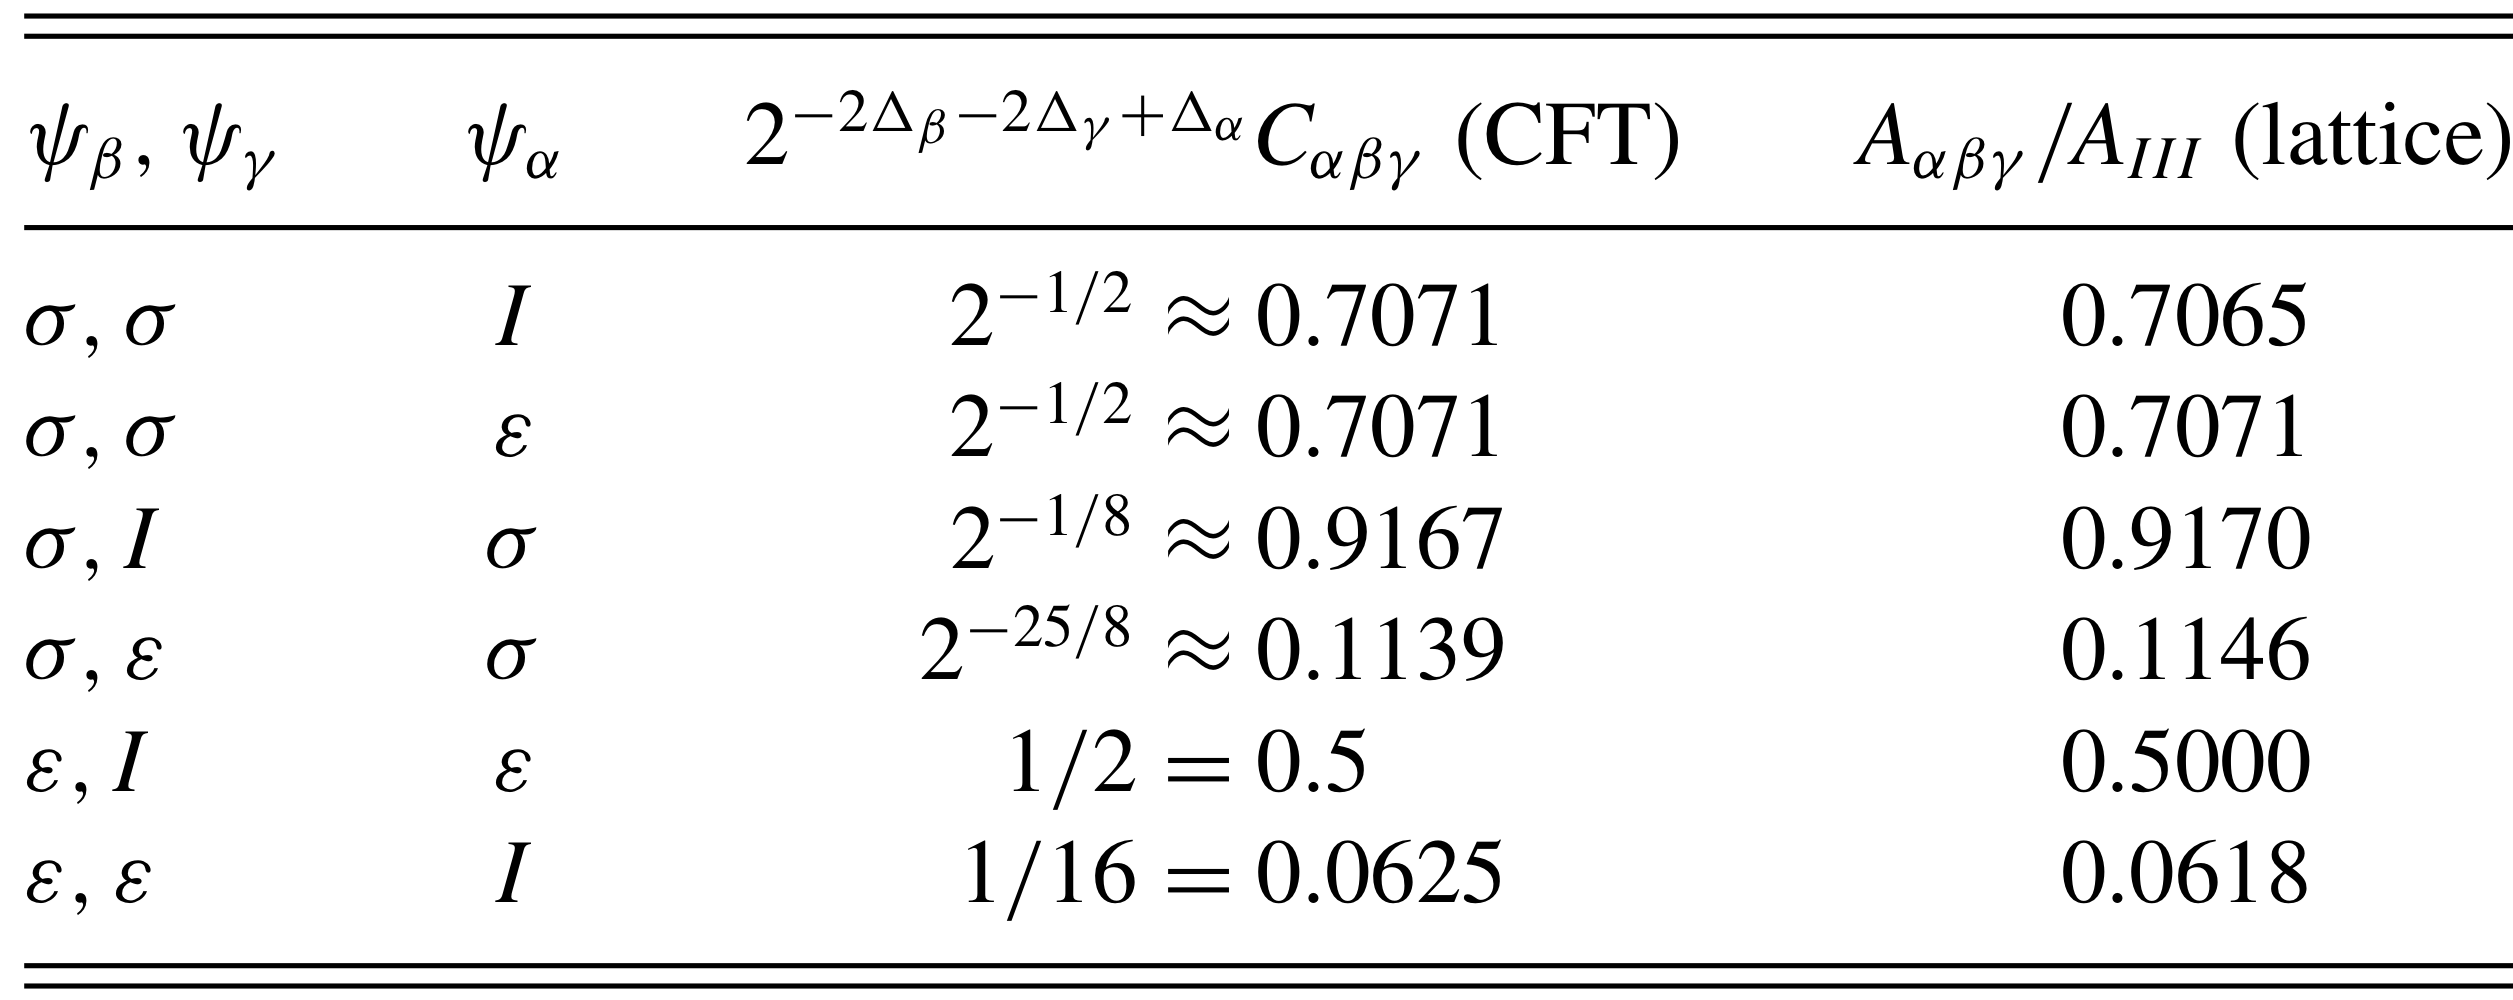


## Calculation of the OPE coefficients from the overlap of wavefunctions

$\frac{A_{\alpha\beta\gamma}}{A_{III}} =2^{\Delta_\alpha-2\Delta_\beta-2\Delta_\gamma} C_{\alpha\beta\gamma}$

In [31]:
#D=64
for i,j,k in [[0,0,0],[0,1,1],[1,1,0],[0,2,2],[2,2,0],[2,1,1],[1,2,1]]:
    a,b,c=(i,j,k)
    Cabc=cal_OPE(table, scaling_dimension,a,b,c)
    print("C{}{}{} = ".format(op[a],op[b],op[c]), np.round(Cabc,5))

CIII =  1.0
CIσσ =  0.88882
CσσI =  0.93102
CIεε =  0.94767
CεεI =  0.7889
Cεσσ =  0.42349
Cσεσ =  0.20938


In [13]:
from tqdm import tqdm
c211=[]
c121=[]
c011=[]
c022 = []
c110 = []
for i in tqdm(range(1,len(A_list))):
    svec, lvec = cal_sl_vec(A_list[i], 2)
    table = fusion_table(svec, lvec)
    scaling_dimension = np.array([0, 0.125, 1])
    c211.append(cal_OPE(table, scaling_dimension,2,1,1))
    c121.append(cal_OPE(table, scaling_dimension,1,2,1))
    c011.append(cal_OPE(table, scaling_dimension,0,1,1))
    c022.append(cal_OPE(table, scaling_dimension,0,2,2))
    c110.append(cal_OPE(table, scaling_dimension,1,1,0))

100%|███████████████████████████████████████████| 12/12 [14:33<00:00, 72.77s/it]


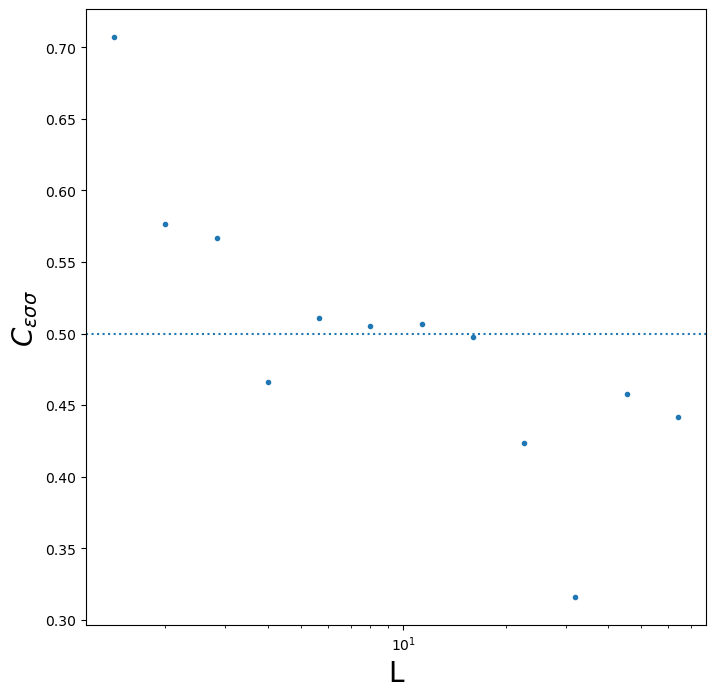

In [14]:
plt.figure(figsize=(8,8))
plt.plot(np.sqrt(2)**(1+np.arange(len(A_list)-1)),c211,".")
plt.axhline(0.5,linestyle=":")
plt.xlabel("L",fontsize=20)
plt.ylabel("$C_{εσσ}$",fontsize=20)
plt.xscale("log")

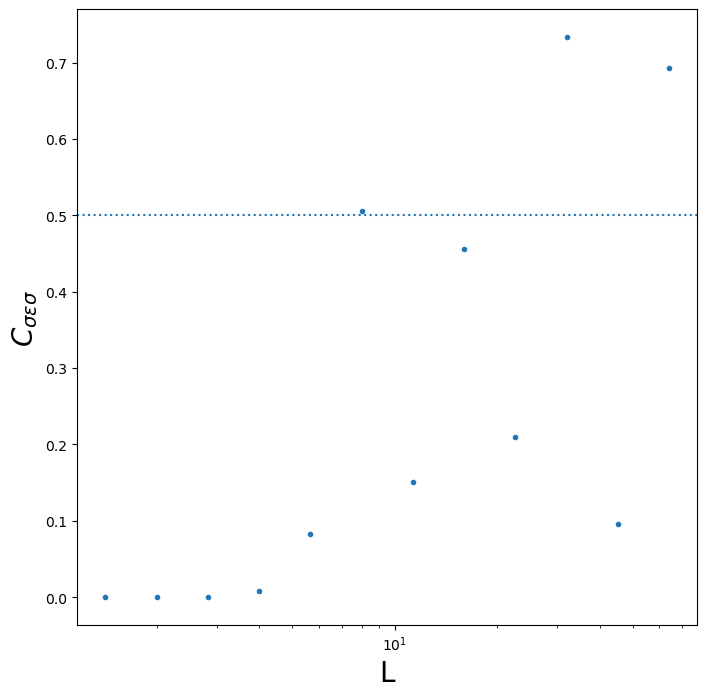

In [15]:
plt.figure(figsize=(8,8))
plt.plot(np.sqrt(2)**(1+np.arange(len(A_list)-1)),c121,".")
plt.axhline(0.5,linestyle=":")
plt.xlabel("L",fontsize=20)
plt.ylabel("$C_{σεσ}$",fontsize=20)
plt.xscale("log")

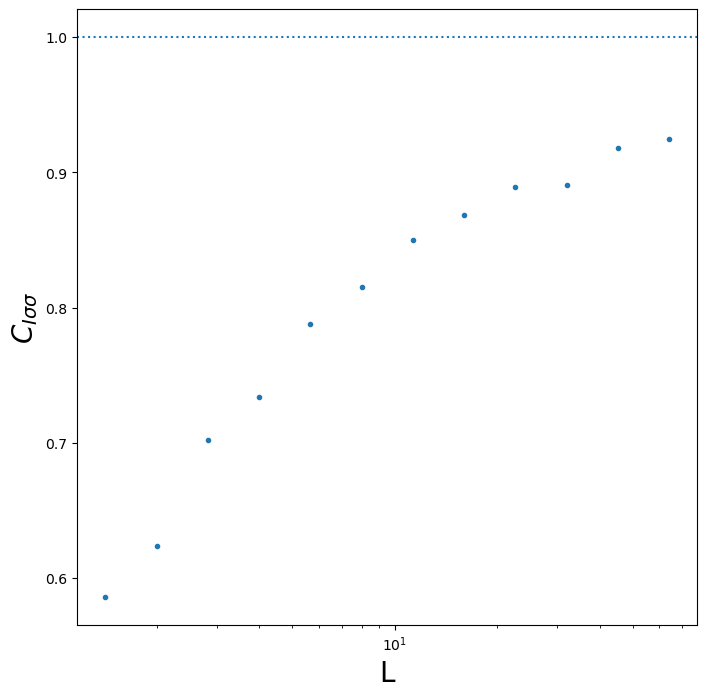

In [16]:
plt.figure(figsize=(8,8))
plt.plot(np.sqrt(2)**(1+np.arange(len(A_list)-1)),c011,".")
plt.axhline(1,linestyle=":")
plt.xlabel("L",fontsize=20)
plt.ylabel("$C_{Iσσ}$",fontsize=20)
plt.xscale("log")

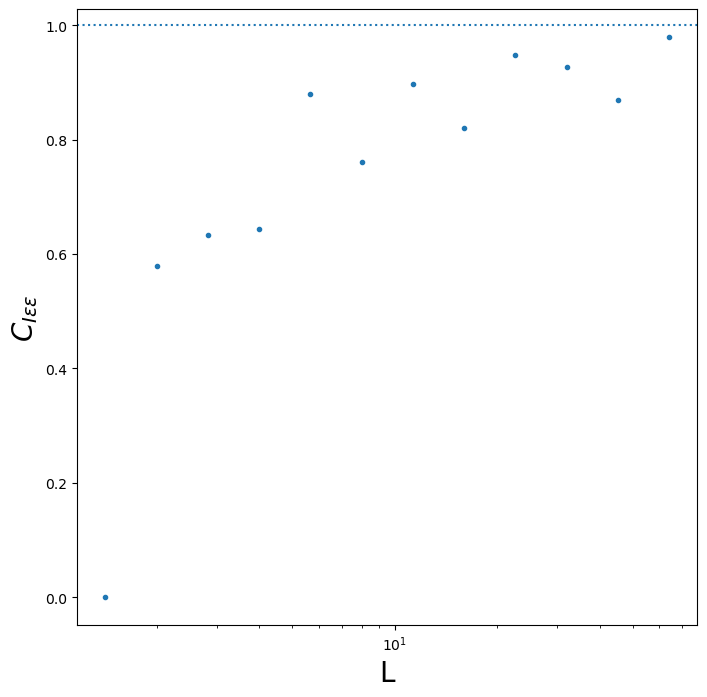

In [17]:
plt.figure(figsize=(8,8))
plt.plot(np.sqrt(2)**(1+np.arange(len(A_list)-1)),c022,".")
plt.axhline(1,linestyle=":")
plt.xlabel("L",fontsize=20)
plt.ylabel("$C_{Iεε}$",fontsize=20)
plt.xscale("log")

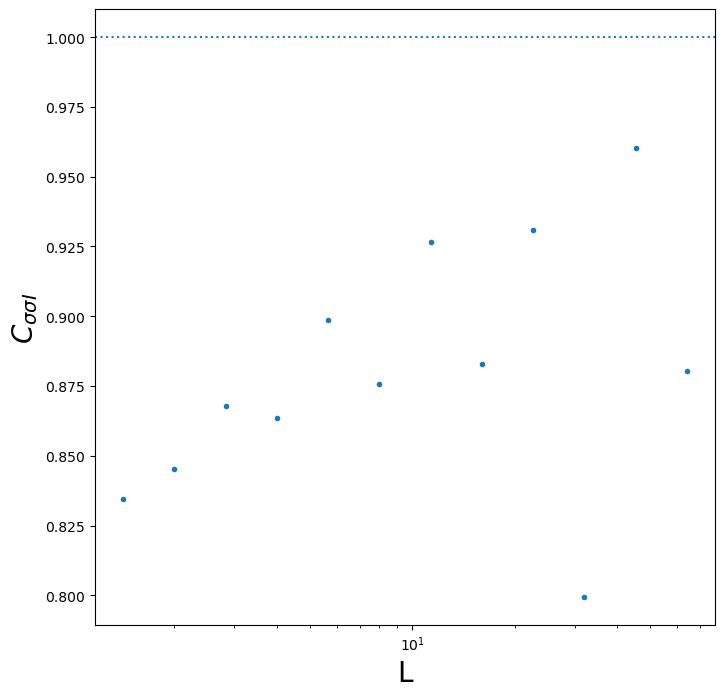

In [18]:
plt.figure(figsize=(8,8))
plt.plot(np.sqrt(2)**(1+np.arange(len(A_list)-1)),c110,".")
plt.axhline(1,linestyle=":")
plt.xlabel("L",fontsize=20)
plt.ylabel("$C_{σσI}$",fontsize=20)
plt.xscale("log")